#1.인트로

##1.1 문제 유형 및 데이터 정리

https://dacon.io/competitions/open/235538/overview/description

주어진 데이터를 바탕으로 선수 이적료를 예측 해보세요!

1. FIFA_train.csv / FIFA_test.csv\
 id : 선수 고유의 아이디\
 name : 이름\
 age : 나이\
 continent : 선수들의 국적이 포함되어 있는 대륙입니다\
 contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다\
 position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등\
 prefer_foot : 선수가 선호하는 발입니다. ex) 오른발\
 reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수\
 stat_overall : 선수의 현재 능력치 입니다.\
 stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.\
 stat_skill_moves : 선수의 개인기 능력치 입니다.\
 value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다\


2. submission.csv (제출 파일 형식)\
id : 선수 고유의 아이디\
value : 예측된 선수 이적 시장 가격을 기입 

##1.2 패키지 로드

In [344]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

##1.3 데이터 로드

###1.3.1 파일 로드

In [345]:
df_train = pd.read_csv('FIFA_train.csv')
df_test = pd.read_csv('FIFA_test.csv')
df_submission = pd.read_csv('submission.csv')

###1.3.2 구글 드라이브 로드

#2.전처리

삭제, 치환, 결측치 추가, 이상치 제거, 표준화, 정규화

##2.1 데이터 확인

In [346]:
df_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [347]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [348]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


In [349]:
df_train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [350]:
df_train.corr().value

id                 -0.544280
age                 0.087319
reputation          0.665982
stat_overall        0.658444
stat_potential      0.611907
stat_skill_moves    0.298500
value               1.000000
Name: value, dtype: float64

##2.2 데이터 시각화

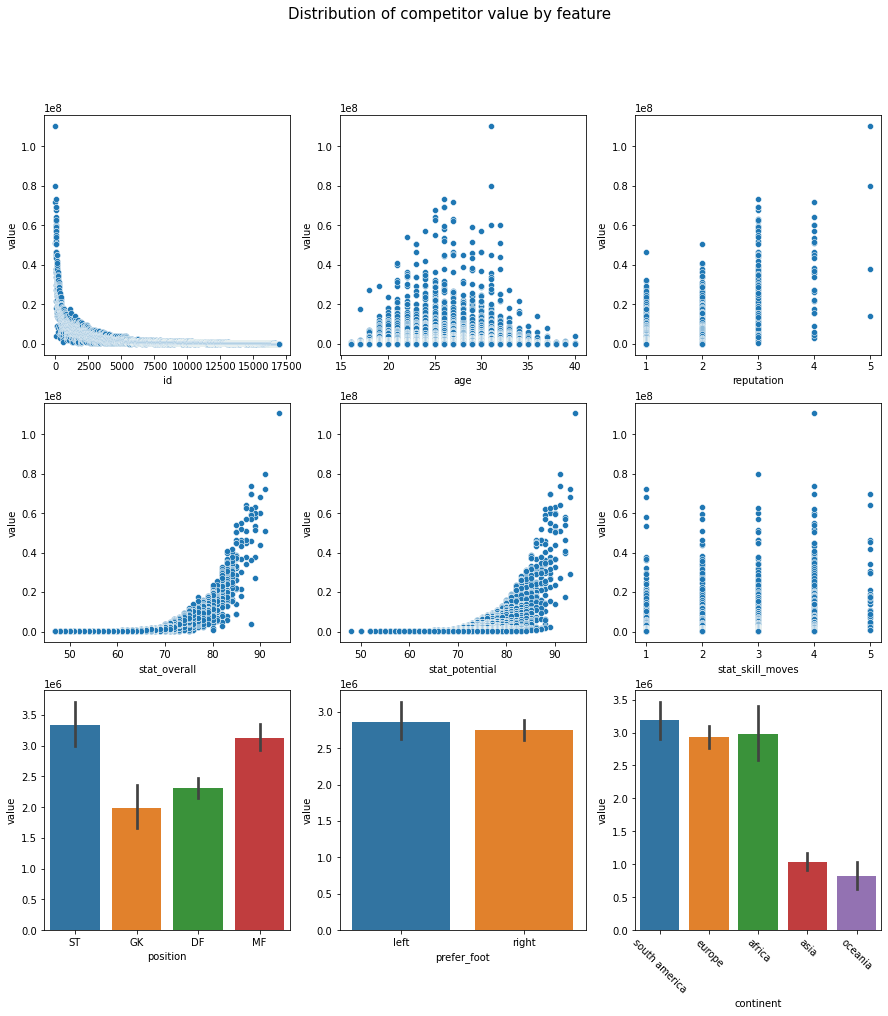

In [351]:
fig, axes = plt.subplots(3, 3,figsize=(15,15))
plt.xticks(rotation=-45)

sns.scatterplot(x = 'id', y = 'value',data = df_train, ax = axes[0][0])
sns.scatterplot(x = 'age', y = 'value',data = df_train, ax = axes[0][1])
sns.scatterplot(x = 'reputation', y = 'value',data = df_train, ax = axes[0][2])
sns.scatterplot(x = 'stat_overall', y = 'value',data = df_train, ax = axes[1][0])
sns.scatterplot(x = 'stat_potential', y = 'value',data = df_train, ax = axes[1][1])
sns.scatterplot(x = 'stat_skill_moves', y = 'value',data = df_train, ax = axes[1][2])
sns.barplot(x = 'position', y = 'value',data = df_train, ax = axes[2][0])
sns.barplot(x = 'prefer_foot', y = 'value',data = df_train, ax = axes[2][1])
sns.barplot(x = 'continent', y = 'value',data = df_train, ax = axes[2][2])

plt.suptitle("Distribution of competitor value by feature",fontsize=15,va='top',ha='center')
plt.show()

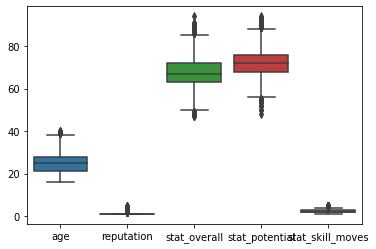

In [352]:
df1 = df_train.drop(["id","value"], axis =1)
sns.boxplot(data = df1)

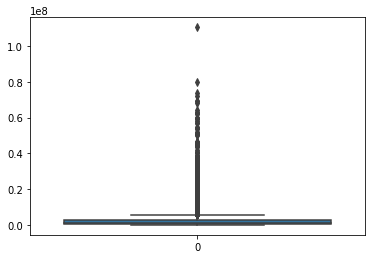

In [353]:
df2 = df_train.value
sns.boxplot(data = df2)

##2.3 이상치 처리

이상치 검출 함수 생성

In [354]:
# def get_outlier(df=None, column=None, weight=1.5):
#   # target 값과 상관관계가 높은 열을 우선적으로 진행
#   quantile_25 = np.percentile(df[column].values, 25)
#   quantile_75 = np.percentile(df[column].values, 75)

#   IQR = quantile_75 - quantile_25
#   IQR_weight = IQR*weight
  
#   lowest = quantile_25 - IQR_weight
#   highest = quantile_75 + IQR_weight
  
#   out_lowest_idx = df[column][ (df[column] < lowest) ].index
#   out_highest_idx = df[column][  (df[column] > highest) ].index  

#   return out_lowest_idx, lowest, out_highest_idx, highest

In [355]:
# 제거할 이상치 검출
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index


  return outlier_idx

In [356]:
# outlier_idx = get_outlier(df=df_train, column='value', weight=1.5)
# print(len(outlier_idx))

In [357]:
# out_lowest_idx, lowest, out_highest_idx, highest = get_outlier(df=df_train, column='value', weight=1.5)
# print(out_lowest_idx)
# print(lowest)
# print(out_highest_idx)
# print(highest)

이상치 값을 양단 값들로 치환

In [358]:
# 이상치 제거
outlier_idx = get_outlier(df=df_train, column='value', weight=1.5)
for idx in outlier_idx:
  df_train.drop(idx, axis=0, inplace=True)

In [359]:
# out_lowest_idx, lowest, out_highest_idx, highest = get_outlier(df=df_train, column='value', weight=1.5)
# for idx in out_highest_idx:
#   df_train.loc[idx,"value"] = highest

# for idx in out_lowest_idx:
#   df_train.loc[idx,"value"] = lowest

In [360]:
df_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
23,41,G. Buffon,40,europe,2019,GK,right,4.0,88,88,1.0,4000000.0
194,314,Dani Alves,35,south america,2019,DF,right,4.0,82,82,4.0,4800000.0
196,317,P. Čech,36,europe,2019,GK,left,4.0,82,82,1.0,3000000.0
248,410,J. Mathieu,34,europe,2019,DF,left,3.0,81,81,2.0,5500000.0
256,420,Everton Andrão,34,south america,2021,MF,right,1.0,80,80,2.0,4500000.0


##2.4 인코딩

In [361]:
df_train = pd.concat([df_train, pd.get_dummies(df_train["continent"])], axis =1)
df_train = pd.concat([df_train, pd.get_dummies(df_train["position"])], axis =1)
df_train = pd.concat([df_train, pd.get_dummies(df_train["prefer_foot"])], axis =1)

df_test = pd.concat([df_test, pd.get_dummies(df_test["continent"])], axis =1)
df_test = pd.concat([df_test, pd.get_dummies(df_test["position"])], axis =1)
df_test = pd.concat([df_test, pd.get_dummies(df_test["prefer_foot"])], axis =1)

##2.5 컬럼 제거

In [362]:
df_train.drop(["name","continent","position","prefer_foot","contract_until"],axis=1,inplace=True)

df_test.drop(["name","continent","position","prefer_foot","contract_until"],axis=1,inplace=True)

In [363]:
df_train.columns

Index(['id', 'age', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves', 'value', 'africa', 'asia', 'europe', 'oceania',
       'south america', 'DF', 'GK', 'MF', 'ST', 'left', 'right'],
      dtype='object')

In [364]:
df_train = df_train[["id",'age', 'reputation', 'stat_overall', 'stat_potential',
       'stat_skill_moves', 'africa', 'asia', 'europe', 'oceania',
       'south america', 'DF', 'GK', 'MF', 'ST', 'left', 'right', 'value']]

In [365]:
df_train.corr().value

id                 -0.773758
age                 0.180620
reputation          0.255898
stat_overall        0.744539
stat_potential      0.563942
stat_skill_moves    0.331204
africa              0.053814
asia               -0.114722
europe             -0.033442
oceania            -0.062916
south america       0.110455
DF                 -0.014044
GK                 -0.102136
MF                  0.039349
ST                  0.052963
left                0.028013
right              -0.028013
value               1.000000
Name: value, dtype: float64

#3.학습 & 예측

In [366]:
splitter = KFold(n_splits=5, shuffle=True, random_state=1)

sta_rafo = Pipeline([("scaler",StandardScaler()),("model",RandomForestRegressor(n_jobs=-1, random_state=1))])

x, y = df_train.iloc[:, 2:6], df_train.iloc[:, -1]

result_train = []
result_predict = []
result_rmse = []
result_mae = []
result_r2 = []

# result_loss

for i, ii in splitter.split(x, y):

    train_x, train_y = x.iloc[i], y.iloc[i]
    test_x, test_y = x.iloc[ii], y.iloc[ii]

    reg = sta_rafo.fit(train_x, train_y)

    result_train.append(reg.score(train_x, train_y))
    result_predict.append(reg.score(test_x, test_y))

    print('train score : ', reg.score(train_x, train_y))
    print('test score : ',  reg.score(test_x, test_y))

    pred_ranfo = sta_rafo.predict(test_x)
    rmse = mean_squared_error(test_y, pred_ranfo)**0.5
    print("RMSE :", rmse)
    result_rmse.append(rmse)


    mae = mean_absolute_error(test_y, pred_ranfo)
    print("MAE :", mae)
    result_mae.append(mae)


    x_data = np.array(test_y)
    y_data = np.array(pred_ranfo)

    r2 = r2_score(x_data, y_data)
    print("r2_score :", r2)
    result_r2.append(r2)

    print("\n")



print("학습률 평균 : ",np.array(result_train).mean())
print("예측률 평균 : ",np.array(result_predict).mean())
print("RMSE 평균 : ",np.array(result_rmse).mean())
print("MAE 평균 : ",np.array(result_mae).mean())
print("R2_SCORE 평균 : ",np.array(result_r2).mean())


train score :  0.9381862708565273
test score :  0.9319812717323103
RMSE : 326074.3719516668
MAE : 147194.45442132765
r2_score : 0.9319812717323103


train score :  0.9408837301233118
test score :  0.9183818808412176
RMSE : 349648.9151147674
MAE : 161141.19953571536
r2_score : 0.9183818808412176


train score :  0.9389320149187593
test score :  0.9289624539253082
RMSE : 344497.1727329404
MAE : 152966.72677604805
r2_score : 0.9289624539253082


train score :  0.9400049899865819
test score :  0.9202006567749856
RMSE : 355198.68915573054
MAE : 157217.3921428893
r2_score : 0.9202006567749856


train score :  0.9412797058615175
test score :  0.9152399887738112
RMSE : 360345.4517054405
MAE : 155567.42367226107
r2_score : 0.9152399887738112


학습률 평균 :  0.9398573423493396
예측률 평균 :  0.9229532504095266
RMSE 평균 :  347152.9201321091
MAE 평균 :  154817.4393096483
R2_SCORE 평균 :  0.9229532504095266


In [367]:
rcs_x = df_test.iloc[:,2:6]

In [368]:
pred = sta_rafo.predict(rcs_x)

In [369]:
df_submission.value = pred
df_submission

,id,value
0,1,4.491781e+06
1,2,4.491781e+06
2,4,4.491781e+06
3,5,4.491781e+06
4,6,4.491781e+06
...,...,...
3823,16924,5.940000e+04
3824,16929,5.240000e+04
3825,16932,5.586333e+04
3826,16937,4.965000e+04


#4.성능 지표 확인

In [370]:
  # pred_ranfo = sta_rafo.predict(x_test)
  # rmse = mean_squared_error(y_test, pred_ranfo)**0.5
  # print("RMSE :", rmse)

  # mae = mean_absolute_error(y_test, pred_ranfo)
  # print("MAE :", mae)

  # r2_score = r2_score(y_test, pred_ranfo)
  # print("r2_score :", r2_score)

In [371]:
# print("학습률 : ",sta_rafo.score(x_train, y_train))
# print("예측률 : ",sta_rafo.score(x_test, y_test))

#5.저장

##5.1 github에 저장

##5.2 파일로 저장

In [372]:
df_submission.to_csv('5번째 수정.csv', index=None)